# Basic regression : Concrete Strength Prediction
There Various Factors that affects the Strength of Concrete Such as Materials Used, Age etc.
Predict the Strength of the Concrete Based on the Components and Other Factors as Predictors.

## About Dataset
There Various Factors that affects the Strength of Concrete Such as Materials Used, Age etc.
Predict the Strength of the Concrete Based on the Components and Other Factors as Predictors.

**Description of Fields are as follows:-**

- CementComponent:- Amount of cement is mixed
- BlastFurnaceSlag:- Amount of Blast Furnace Slag is mixed
- FlyAshComponent:- Amount of FlyAsh is mixed
- WaterComponent:- Amount of water is mixed
- SuperplasticizerComponent:- Amount of Super plasticizer is mixed
- CoarseAggregateComponent:- Amount of Coarse Aggregate is mixed
- FineAggregateComponent:- Amount of Coarse Aggregate is mixed
- AgeInDays:- How many days it was left dry
- Strength:- What was the final strength of concrete- (Target)

In a regression problem, the aim is to predict the output of a continuous value, like a price or a probability, Contrast this with a classifcation problem, where the aim is to select a class from a list of classes (for example, where a picture contains a apple or an orange, recognizing which fruis is in the picture)
</br></br>
This notebook uses the **Conreate Strength** dataset build models to predict the strength of concrete. This notebooks uses the Keras API.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

np.set_printoptions(precision=3,suppress=True)

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.10.1


## Get the data
First download and import the dataset using pandas:

In [3]:
column_names=[
              'CementComponent',
              'BlastFurnaceSlag',
              'FlyAshComponent',
              'WaterComponent',
              'SuperplasticizerComponent',
              'CoarseAggregateComponent',
              'FineAggregateComponent',
              'AgeInDays',
              'Strength']
raw_dataset=pd.read_csv('./data/ConcreteStrengthData.csv')

In [4]:
dataset=raw_dataset.copy()
dataset.head()

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


## Clean the data

In [5]:
dataset.isna().sum()

CementComponent              0
BlastFurnaceSlag             0
FlyAshComponent              0
WaterComponent               0
SuperplasticizerComponent    0
CoarseAggregateComponent     0
FineAggregateComponent       0
AgeInDays                    0
Strength                     0
dtype: int64

## Split the data into training and test sets
Now, split the dataset into a training set and a test set. You will use the test set in the final evaluation of your models.

In [6]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

## Inspect the data
Review the joint distribution of a few pairs columns from the training set.
</br>
</br>
The top row suggests the Strength is a function of all the other parameters. The other rows indicate they are function of each other.

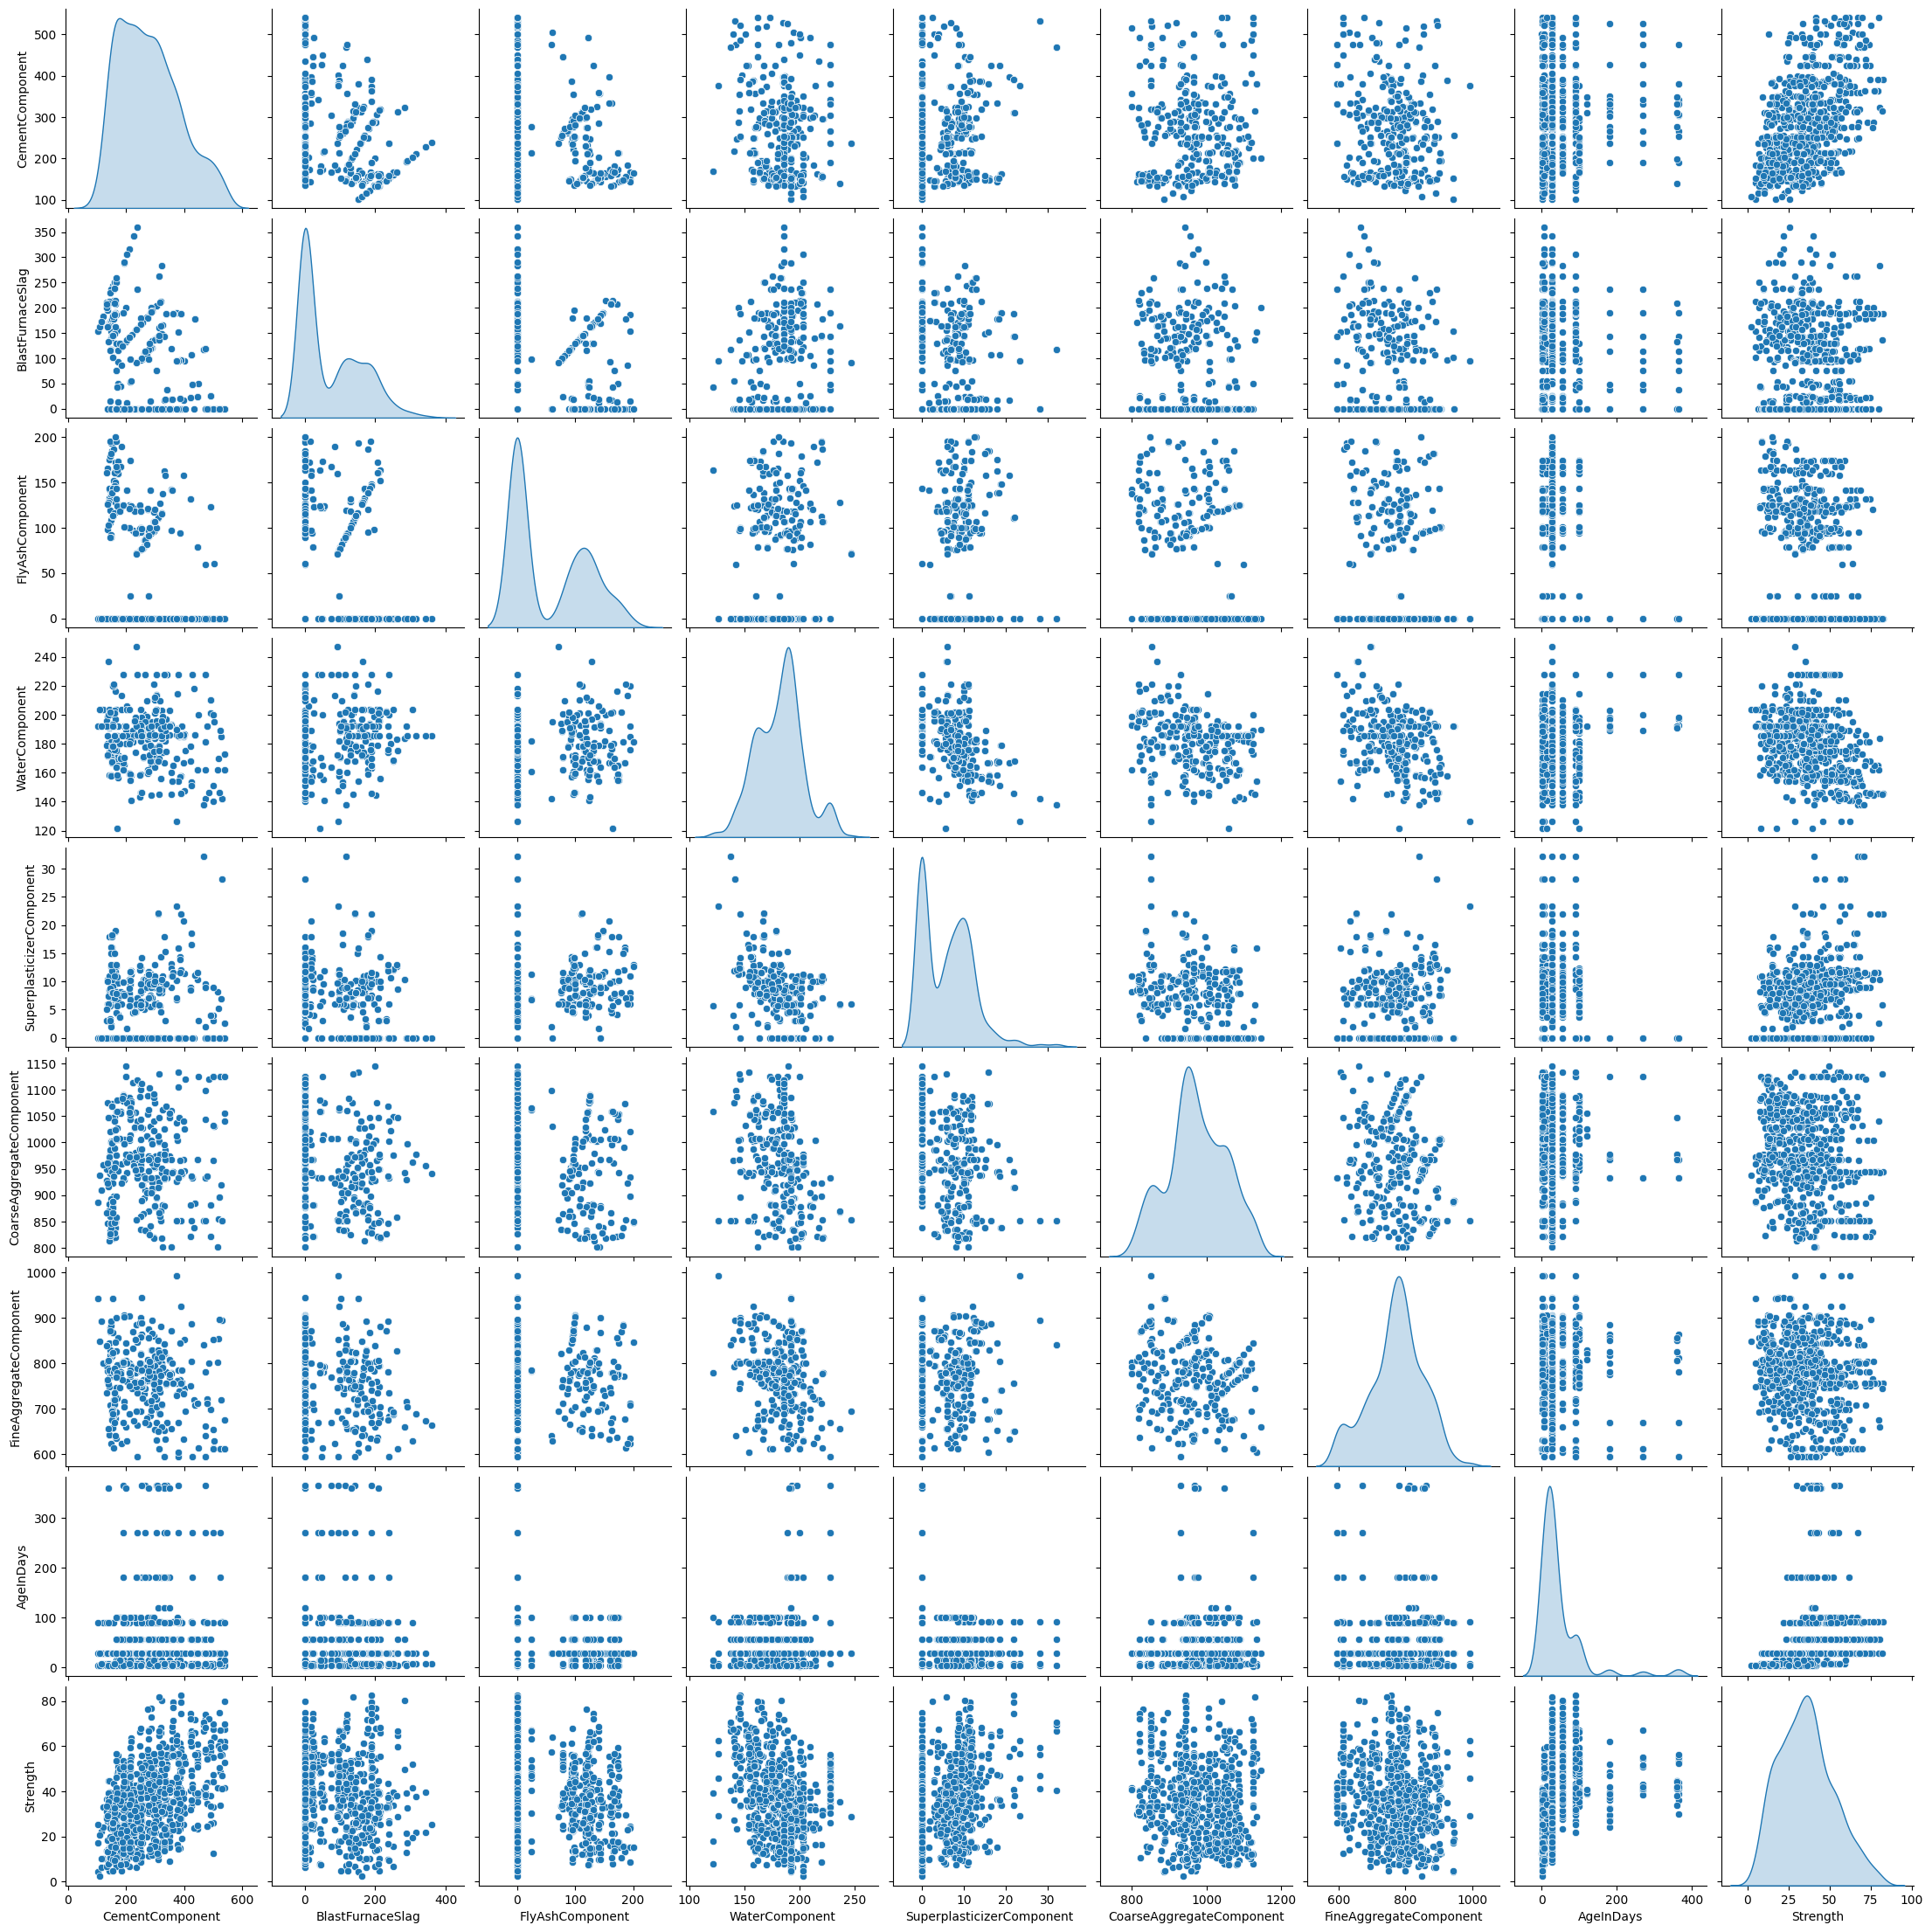

In [7]:
sns.pairplot(train_dataset,diag_kind='kde')

Let's also check the overall statistics. Note how each feature covers a vert different range.

In [8]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CementComponent,824.0,280.272694,104.483467,102.00,193.125,266.000,350.0000,540.0
BlastFurnaceSlag,824.0,73.171238,85.865727,0.00,0.000,22.000,142.5000,359.4
FlyAshComponent,824.0,55.318325,64.098118,0.00,0.000,0.000,118.3000,200.1
WaterComponent,824.0,182.029490,21.287699,121.80,164.900,185.700,192.0000,247.0
SuperplasticizerComponent,824.0,6.147816,6.000795,0.00,0.000,6.100,10.1250,32.2
CoarseAggregateComponent,824.0,973.991019,77.755840,801.00,932.000,968.000,1030.2500,1145.0
FineAggregateComponent,824.0,771.898301,80.031529,594.00,721.750,779.300,824.0000,992.6
AgeInDays,824.0,45.708738,63.603343,1.00,7.000,28.000,56.0000,365.0
Strength,824.0,35.739478,16.582095,2.33,23.520,34.425,46.2075,82.6


## Split features from labels
Separate the target value - the 'label' - from the features. This label is the value thay we will train the model to predict

In [9]:
train_features=train_dataset.copy()
test_features=test_dataset.copy()

train_labels=train_features.pop('Strength')
test_labels=test_features.pop('Strength')

## Normalization
In the table of statistics it's easy to see how different the ranges of each feature are:

In [10]:
train_dataset.describe().transpose()[['mean','std']]

,mean,std
CementComponent,280.272694,104.483467
BlastFurnaceSlag,73.171238,85.865727
FlyAshComponent,55.318325,64.098118
WaterComponent,182.029490,21.287699
SuperplasticizerComponent,6.147816,6.000795
CoarseAggregateComponent,973.991019,77.755840
FineAggregateComponent,771.898301,80.031529
AgeInDays,45.708738,63.603343
Strength,35.739478,16.582095


It is good practice to normalize features that use different scales and ranges
</br></br>
One reason this is important is beacause the features are multiplied by the model weights. So, the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.
</br></br>
Although a model might converge without feature normalization, normalization makes training much more stable.

## The Normalization Layer
The `tf.keras.layers.Normalization` is a clean and simple way to add feature normalization into our model.
</br>
</br>
This first step is to create the layer

In [11]:
normalizer=tf.keras.layers.Normalization(axis=-1)

Then, fit the state of preprocessing layer to the data by callling `Normalization.adapt`

In [12]:
normalizer.adapt(np.array(train_features))

Calculate the mean and variance, and store them in the layer

In [13]:
print(normalizer.mean.numpy())

[[280.273  73.171  55.318 182.029   6.148 973.991 771.898  45.709]]


When the layer is called, returns the input data, with each feature independently normalized

In [14]:
first=np.array(train_features[:1])

with np.printoptions(precision=2,suppress=True):
    print('First example:',first)
    print()
    print('Normalized:',normalizer(first).numpy())

First example: [[ 500.    0.    0.  200.    0. 1125.  613.    3.]]

Normalized: [[ 2.1  -0.85 -0.86  0.84 -1.03  1.94 -1.99 -0.67]]


## Linear Regression
Before building a deep neural network model, start with linear regression using one and several variables.
</br>
</br>
## Linear regression with one variable
Begin with a single-variable linear regression to predict `Strength` from `Cement Component`
</br>
</br>
Training a model with `tf.keras` typically starts by defining the model architecture. Use a `tf.keras.Sequential` model, which represents a sequence of steps.
</br>
</br>
There are two steps in our single-variable linear regression model:
- Normalize the `Cement Component` input features using the `tf.keras.layers.Normalization` preprocessing layer.
- Apply a linear transformation ($y = mx+b$) to produce 1 output using a linear layer (`tf.keras.layers.Dense`)</br>

The number of inputs can either be set by the `input_shape` argument, or automatically when the model is run for the first time.
</br>
</br>
First, create a Numpy array made of the `Cement Component` features. Then instantiate the `tf.keras.layers.Normalization` and fits its state to the `Cement Component` data:

In [15]:
cementComponent=np.array(train_features['CementComponent'])
cementComponent_normalizer=layers.Normalization(input_shape=[1,],axis=None)
cementComponent_normalizer.adapt(cementComponent)

Build the Keras Sequential model

In [16]:
cementComponent_model=tf.keras.Sequential([
    cementComponent_normalizer,
    layers.Dense(units=1)
])

cementComponent_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


This model will predict `'Strength'` from `'Cement Component'`
</br>
</br>
Run the untrained model on the first 10 `Cement Component` values. The output won't be good, but notice that it has the expected shape of `(10,1)`

In [17]:
cementComponent_model.predict(cementComponent[:10])

1/1 [==============================] - 1s 1s/step


array([[ 0.379],
       [-0.272],
       [ 0.142],
       [ 0.417],
       [-0.213],
       [ 0.171],
       [ 0.131],
       [-0.155],
       [ 0.448],
       [ 0.106]], dtype=float32)

Once the model is built, configure thr training procedure using the Keras `Model.compile` method. The most important arguments to compile are the `loss` and the `optimizer`, since these define what will be optimized  (`mean_absolute_erro`) and how (using the `tf.keras.optimizers.Adam`)

In [18]:
cementComponent_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)

Use Keras `model.fit` to execute the training for 100 epochs

In [19]:
%%time
history=cementComponent_model.fit(
    train_features['CementComponent'],
    train_labels,
    epochs=100,
    verbose=0,
    validation_split=0.2
)

CPU times: total: 1.2 s
Wall time: 9.89 s


Visualize the model's training progress using the stats stored in `history` object:

In [20]:
hist=pd.DataFrame(history.history)
hist['epoch']=history.epoch
hist.tail()

,loss,val_loss,epoch
95,11.877255,11.773045,95
96,11.882904,11.752525,96
97,11.887345,11.802812,97
98,11.882345,11.789653,98
99,11.879021,11.781734,99


In [21]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([3,15])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

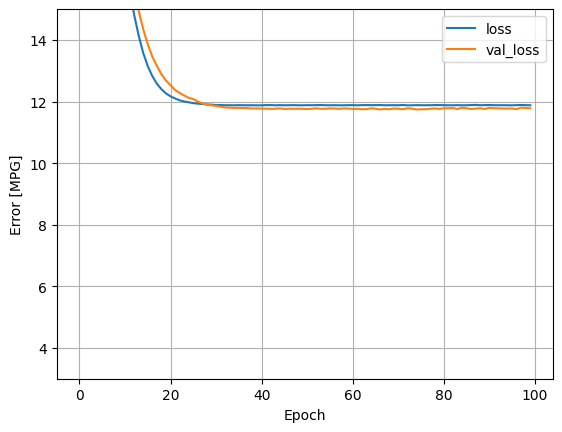

In [22]:
plot_loss(history)

Collect the results on the test set for later:

In [23]:
test_results={}

test_results['cementComponent_model']=cementComponent_model.evaluate(
    test_features['CementComponent'],
    test_labels,
    verbose=0
)

Since this is a single variable regression, it's easy to view the model's predictions as a function of the input

In [24]:
x=tf.linspace(100,500,501)
y=cementComponent_model.predict(x)

16/16 [==============================] - 0s 3ms/step


In [25]:
def plot_cementComponent(x,y):
    plt.scatter(train_features['CementComponent'],train_labels,label='Data')
    plt.plot(x,y,color='k',label='Predictions')
    plt.xlabel('Cement Component')
    plt.ylabel('Strength')
    plt.legend()

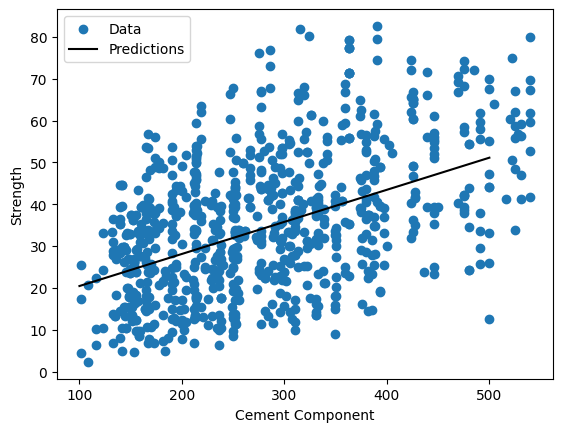

In [26]:
plot_cementComponent(x,y)

## Linear regression with multiple inputs
We can use an almost identical setup to make predictions based on multiple inputs. This model still does the same ($y = mx+b$) expect that m is a matrix and b is a vector.
</br>
</br>
Create a two-step Keras Sequential model again with the first layer being `normalizer` (`tf.keras.layers.Normalization(axis=-1)`) we defined earlier and adapted to the whole dataset

In [27]:
linear_model=tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

When we call `Model.predict` on a batch of inputs, it produces `units=1` outputs for each exmaple:

In [28]:
linear_model.predict(train_features[:10])

1/1 [==============================] - 0s 57ms/step


array([[ 2.359],
       [-0.156],
       [-0.659],
       [ 0.944],
       [-0.513],
       [-0.496],
       [ 0.286],
       [-1.126],
       [ 1.831],
       [ 2.833]], dtype=float32)

When we call the model, its weight matrices will be build - check that the `kernel` weights (the $m$ in $y=mx+b$) have a shape of (`8, 1`)

In [29]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(8, 1) dtype=float32, numpy=
array([[ 0.026],
       [-0.805],
       [-0.679],
       [ 0.123],
       [-0.444],
       [-0.248],
       [-0.539],
       [ 0.171]], dtype=float32)>

Configure the model with Keras `Model.compile` and train with `Model.fit` for 100 epochs

In [30]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)

In [31]:
%%time
history=linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    verbose=0,
    validation_split=0.2
)

CPU times: total: 2.28 s
Wall time: 11 s


Using all the inputs in this regression model achieves a much lower training and validation error than the `cementComponent_model` which had one input

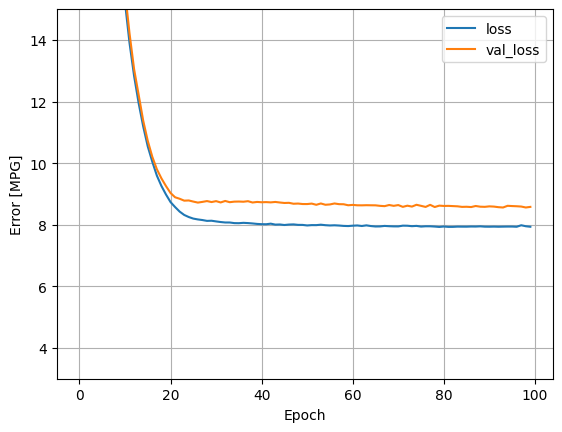

In [32]:
plot_loss(history)

Collect the results on the test set for later

In [33]:
test_results['linear_model']=linear_model.evaluate(
    test_features,test_labels,verbose=0
)

## Regression with a deep neural network (DNN)
In the previous section we implemented two linear models for a single and multiple inputs.
</br>
</br>
Here, we will implement single-input and multiple-input DNN models.
</br>
</br>
The code is basically the same expect the model is expanded to include som "hidden" non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs
</br>
</br>
These models will contain a few more layers than the linear model
- The normalization layer, as before (with `cementComponent_normalizer` for a single input moedl and `normalizer` for a multiple-input model)
- Two hidden, non-linear, `Dense` layers with the ReLU (`relu`) activation function nonlinearlity
- A linear `Dense` single-output layer

Both models will use the same training procedure, so the `compile` method is included in the `build_and_compile_model` function below

In [34]:
def build_and_compile_model(norm):
    model=keras.Sequential([
        norm,
        layers.Dense(64,activation='relu'),
        layers.Dense(64,activation='relu'),
        layers.Dense(1)
    ])
    model.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(0.001))
    return model

## Regression using a DNN and a single input
Create a DNN model with only 'Cement Component' as inpu and `cementComponent_normalizer` (defined earlier) as the normalization layer:

In [35]:
dnn_cementComponent_model=build_and_compile_model(cementComponent_normalizer)

This model has a quite few more trainable parameters than the linear models:

In [36]:
dnn_cementComponent_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                128       
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


Train the model with Keras `Model.fit`

In [37]:
%%time
history=dnn_cementComponent_model.fit(
    train_features['CementComponent'],
    train_labels,
    validation_split=0.2,
    verbose=0,
    epochs=100
)

CPU times: total: 2.61 s
Wall time: 11.7 s


This model does slightly better than the linear single-input `cementComponent_model`

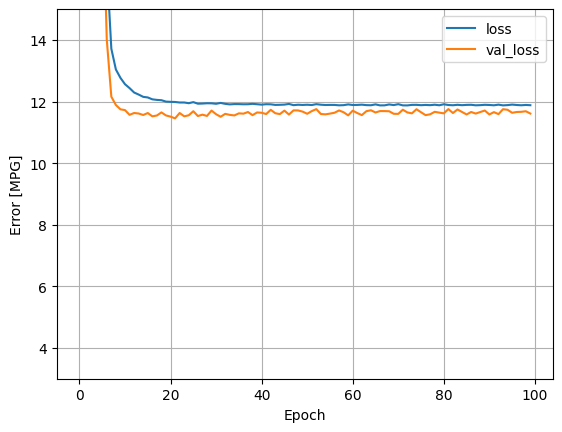

In [38]:
plot_loss(history)

If we plot the predictions as function of `Cement Component`, we should notice how this model takes advantage of the nonlinearity provided by the hidden layers.

In [39]:
x=tf.linspace(100,500,501)
y=dnn_cementComponent_model.predict(x)

16/16 [==============================] - 0s 2ms/step


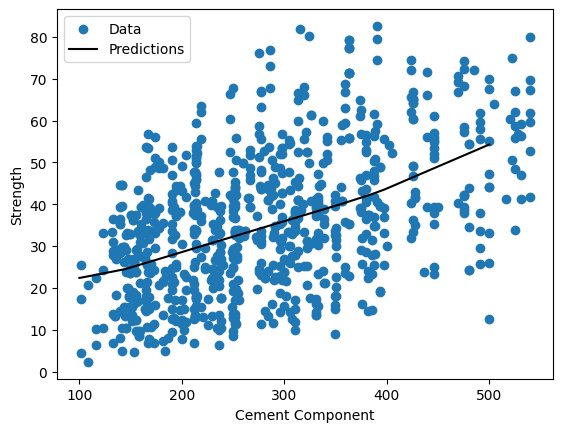

In [40]:
plot_cementComponent(x,y)

Collect the results on the test set for later

In [41]:
test_results['dnn_cementComponent']=dnn_cementComponent_model.evaluate(
    test_features['CementComponent'],test_labels,verbose=0
)

## Refgression using a DNN and multiple inputs
Repeat the previous process using all the inputs. The model's performance slightly improves on the validation dataset

In [42]:
dnn_model=build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 8)                17        
 n)                                                              
                                                                 
 dense_5 (Dense)             (None, 64)                576       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,818
Trainable params: 4,801
Non-trainable params: 17
_________________________________________________________________


In [43]:
%%time 
history=dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0,
    epochs=100
)

CPU times: total: 1.45 s
Wall time: 10.8 s


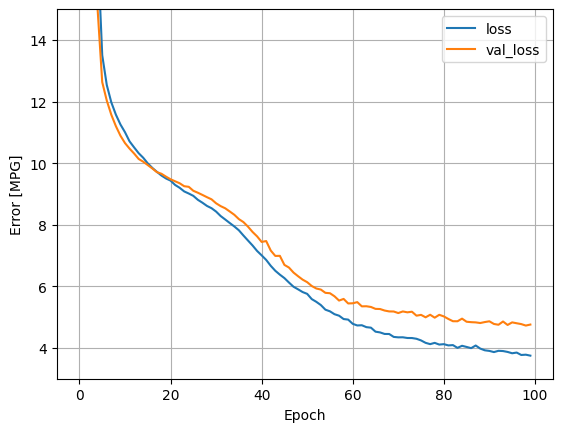

In [44]:
plot_loss(history)

Collect the results on the test set

In [45]:
test_results['dnn_model']=dnn_model.evaluate(test_features,test_labels,verbose=0)

## Performance
Since all models have been trained, we can review their test set performance

In [46]:
pd.DataFrame(test_results,index=['Mean absolute error [Strength]']).T

,Mean absolute error [Strength]
cementComponent_model,11.846701
linear_model,8.193254
dnn_cementComponent,11.868266
dnn_model,4.570664


These results match the validation error observed during training

## Make predictions
We can make predicitons with the `dnn_model` on the test set using Keras `Model.predict` and review the loss:

7/7 [==============================] - 0s 3ms/step


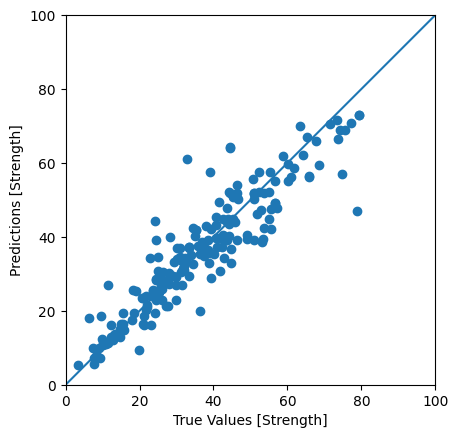

In [47]:
test_predictions=dnn_model.predict(test_features).flatten()

a=plt.axes(aspect='equal')
plt.scatter(test_labels,test_predictions)
plt.xlabel('True Values [Strength]')
plt.ylabel('Predictions [Strength]')
lims=[0,100]
plt.xlim(lims)
plt.ylim(lims)
_=plt.plot(lims,lims)

it appears that the model predicts reasonbly well
</br>
</br>
Now, check the error distribution

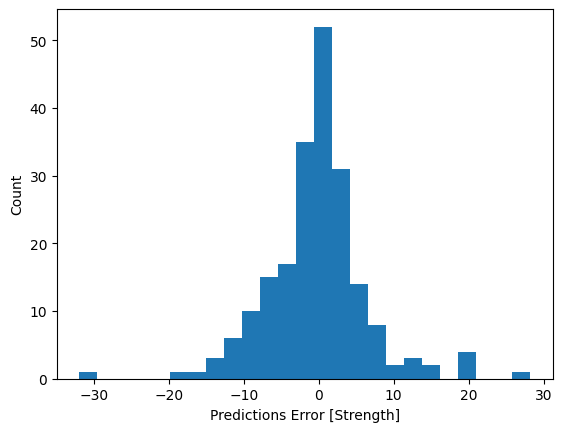

In [48]:
error=test_predictions-test_labels
plt.hist(error,bins=25)
plt.xlabel('Predictions Error [Strength]')
_=plt.ylabel('Count')

If we're happy with the model, save it for layer use with `Model.save`

In [49]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model\assets


If we reloaded the model, it gives identical output:

In [50]:
reloaded=tf.keras.models.load_model('dnn_model')
test_results['reloaded']=reloaded.evaluate(
    test_features,test_labels,verbose=0
)

In [51]:
pd.DataFrame(test_results,index=['Mean absolute error [Strength]']).T

,Mean absolute error [Strength]
cementComponent_model,11.846701
linear_model,8.193254
dnn_cementComponent,11.868266
dnn_model,4.570664
reloaded,4.570664


## Conclusion
This notebook introduces a few techniques to handle a regression problem. Here are a few more tips that may help:
- Mean squared error (MSE) (`tf.keras.losses.MeanSquaredError`) and mean absolute error (MAE) (`tf.keras.losses.MeanAbsoluteError`) are common loss functions used for regression problems. MAE is lees sensitive to outliers. Different loss function are used for classification problems.
- Similarly, evaluation metrics used for regression differ from classification.
- When numeric input data features values with different ranges, each feature should be scaled indepenetly to the same ranege.
- Overfitting is a common problem for DNN models.